# Estimation of MET cross section with Madgraph 3.6.0

In [7]:
# !pip install numpy pandas sympy matplotlib 
# !wget https://launchpad.net/mg5amcnlo/3.0/3.6.x/+download/MG5_beta_v3.6.2.tgz
# !sudo apt-get update

## Downlaod MG5 and dependencies

In [8]:
import wget
import tarfile
import os
import subprocess


MG5_LATEST = '3.6.3'

def get_mg5(version: str = MG5_LATEST, output_dir: str | None =  None):
    '''Get the latest version of MG5 and saves it to the disk'''
    
    if output_dir is None:
        output_dir = os.getcwd()

    file_name = f'MG5_aMC_v{version}.tar.gz'
    mg5_url = f"http://launchpad.net/madgraph5/3.0/3.6.x/+download/{file_name}"

    wget.download(mg5_url, out = output_dir)
    print(f'Downloaded at {output_dir}/{file_name}')


def untar_file(file: str, output_dir: str | None =  None):

    '''Alias to untar some tar.gz file to a output_dir folder'''

    if output_dir is None:
        output_dir = os.getcwd()

    subprocess.run(
        ["tar", "-xzfv", file, "-C", output_dir],
        check=True
    )

    print('All done!')

## How to use this module

In [ ]:
# # !pip install madpy
# 

# Install madgraph from github
# !git clone https://github.com/mg5amcnlo/mg5amcnlo.git
#
#





## Install MadDM

# !git clone https://github.com/maddmhep/maddm.git

# git checkout dev
# On terminal
# cd maddm
# git switch dev
# cp -R . ../mg5amcnlo/PLUGIN/maddm

# install pythia8
# install PPPC4DMID

In [14]:



MADGRAPH_PATH = f"../mg5amcnlo/"

import sys,os
sys.path.append(MADGRAPH_PATH)

In [10]:
import sys,os
sys.path.append('..')
from src.madpy import SM_PARTICLE_DataFrame

In [15]:
from madgraph.interface.master_interface import MasterCmd

mg = MasterCmd()
# Set up the process

mg.exec_cmd("import model sm")




In [16]:
## Write a automatic script based on python comands 

## Install models and plugins

### [DMSimp](https://feynrules.irmp.ucl.ac.be/wiki/DMsimp)

In [11]:
### DMSimp
# - https://feynrules.irmp.ucl.ac.be/wiki/DMsimp 
mg.exec_cmd("import model DMsimp_s_spin0")


--2025-08-19 15:11:07--  http://feynrules.irmp.ucl.ac.be/raw-attachment/wiki/DMsimp/DMsimp_s_spin0.zip
Resolving feynrules.irmp.ucl.ac.be (feynrules.irmp.ucl.ac.be)... 130.104.48.109
Connecting to feynrules.irmp.ucl.ac.be (feynrules.irmp.ucl.ac.be)|130.104.48.109|:80... connected.
HTTP request sent, awaiting response... 200 Ok
Length: 28044 (27K) [application/zip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......                         100%  129K=0.2s

2025-08-19 15:11:08 (129 KB/s) - ‘tmp.tgz’ saved [28044/28044]



Archive:  tmp.tgz
   creating: DMsimp_s_spin0/
  inflating: DMsimp_s_spin0/__init__.py  
  inflating: DMsimp_s_spin0/coupling_orders.py  
  inflating: DMsimp_s_spin0/couplings.py  
  inflating: DMsimp_s_spin0/CT_couplings.py  
  inflating: DMsimp_s_spin0/CT_vertices.py  
  inflating: DMsimp_s_spin0/decays.py  
  inflating: DMsimp_s_spin0/DMsimp_s_spin0_UFO.log  
  inflating: DMsimp_s_spin0/function_library.py  
  inflating: DMsimp_s_spin0/lorentz.py  
  inflating: DMsimp_s_spin0/object_library.py  
  inflating: DMsimp_s_spin0/parameters.py  
  inflating: DMsimp_s_spin0/particles.py  
  inflating: DMsimp_s_spin0/propagators.py  
  inflating: DMsimp_s_spin0/vertices.py  
  inflating: DMsimp_s_spin0/write_param_card.py  


Pass the definition of 'j' and 'p' to 5 flavour scheme.


### [MadDM](https://maddmhep.github.io/maddm/dev/index.html)

In [12]:
### MadDM
# - https://maddmhep.github.io/maddm/dev/index.html

mg.exec_cmd("install maddm")

--2025-08-19 15:11:55--  http://madgraph.mi.infn.it//Downloads/maddm/maddm_V3.2.13.tar.gz
Resolving madgraph.mi.infn.it (madgraph.mi.infn.it)... 192.135.21.75
Connecting to madgraph.mi.infn.it (madgraph.mi.infn.it)|192.135.21.75|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://madgraph.mi.infn.it//Downloads/maddm/maddm_V3.2.13.tar.gz [following]
--2025-08-19 15:11:55--  https://madgraph.mi.infn.it//Downloads/maddm/maddm_V3.2.13.tar.gz
Connecting to madgraph.mi.infn.it (madgraph.mi.infn.it)|192.135.21.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609041 (595K) [application/x-gzip]
Saving to: ‘maddm.tgz’

     0K .......... .......... .......... .......... ..........  8%  113K 5s
    50K .......... .......... .......... .......... .......... 16% 1.21M 2s
   100K .......... .......... .......... .......... .......... 25%  271K 2s
   150K .......... .......... .......... .......... .......... 33% 11.9M 1s
   200K .........

No module named 'maddm_interface'
 pyvers =  2 [madgraph_interface.py at line 6721]


In [13]:
mg.exec_cmd("install pythia8")

LHAPDF was not found. Do you want to install LHPADF6? (recommended)  y/n >[y] [60s to answer] 


Installer HEPToolInstaller.py is now processing the following command:
   /home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3/HEPTools/HEPToolsInstallers/HEPToolInstaller.py lhapdf6 --prefix=/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3/HEPTools --cpp_standard_lib=-lstdc++ --mg5amc_py8_interface_tarball=http://madgraph.mi.infn.it//Downloads/MG5aMC_PY8_interface/MG5aMC_PY8_interface_V1.3.tar.gz --logging=0 --mg5_path=/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3 --mg5_path=/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3
/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3/HEPTools/HEPToolsInstallers/HEPToolInstaller.py:650: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mg5_version = LooseVersion(out[0])
/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3/HEPTools/HEPToolsInstallers/HEPToolInstaller.py:543: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if tool_name in ['lhapdf6', 'lhapdf'] and MG5_version and M

RETURN CODE AT PYTHON: 1


    > A problem occured during the installation of 'lhapdf6'.
    > Return code of the installation is 1
    > See installation log at '/home/mjrxy/MadPy/mg5_versions/MG5_aMC_v3_6_3/HEPTools/lhapdf6_py3/lhapdf6_install.log' 


InvalidCmd: Installation of lhapdf6 failed.

In [ ]:
mg.exec_cmd("install PPPC4DMID")

In [ ]:
# import model DMsimp_s_spin0
# generate p p > xd xd~ a / a z [QCD]
## Generate files at output
mg.exec_cmd(f"output {output_process_folder} -f")


In [ ]:
output_process_folder = '../workdir/my_test_proc'
mg.exec_cmd("generate p p > t t~ j")

In [34]:
cmd_launch = """launch set mt scan:[170,175,180] set nevents 1k"""

In [ ]:
file_mg5 = """generate p p > t t~ j
output MYDIRECTORY
launch MYDIRECTORY
    set mt 170 # changing the top mass
    set wt Auto # changing the top width
    set ptj 40 # changing the ptj cut
launch
    set mt 175 # changing the top mass
    set wt Auto # changing the top width
launch
    set mt 180 # changing the top mass
    set wt Auto # changing the top width
launch MYDIRECTORY -i
    print_results --path=./cross_section_top.txt --format=short"""

In [ ]:
madeventcmd.exec_cmd(cmd_launch)

In [ ]:
mg.exec_cmd(f"""launch {output_process_folder}
set param_card mass 5000001  1.720000e+02
launch {output_process_folder} -i
print_results --path=./cross_section_top.txt --format=short""")

In [ ]:
set param_card mass 5000001  1.720000e+02

In [ ]:
https://answers.launchpad.net/mg5amcnlo/+faq/2735

# MadGraph5_aMC@NLO 2.3.3 introduces a new method to performs a scan over parameter (only entry of the param_card can be handle by this new syntax, for run_card parameter scan, please see FAQ#2186).
# This scan syntax is compatible with
# 1) LO generation (param_card.dat)
# 2) NLO generation (param_card.dat)
# 3) LO/NLO reweighting (reweighting_card.dat)

# The main idea is that in the param_card instead of having the following line:
# Block mass
#     5 4.700000e+00 # MB
#     6 1.730000e+02 # MT
# you can put
# Block mass
#     5 4.700000e+00 # MB
#     6 scan: [171, 173, 175] # MT

# The above syntax is 100% equivalent to the following script: (see FAQ#2186)
# launch
#   set MT 171
# launch
#   set MT 173
# launch
#   set MT 175

# Note:
# 1) A summary file with the cross-section for the various entry of the card will be created at the end of the run
# 2) if some width are set on "Auto" they will be re-computed for each point of the scan.
# 3) The above syntax launches three sequential run creating each of them an associate events file.
# 4) this options is compatible with scripting (i.e. "set MT scan:[171,173,175]" is supported at the same level as "set MT 171")
# (see FAQ #2186)

# ###############################################################
# # 2D scan
# ###############################################################
# you can do
# Block mass
#     5 scan: [3,4,5,6] # MB
#     6 scan: [171, 173, 175] # MT
# and this will compute 12 (4*3) cross-sections

# ###############################################################
# # 1D scan but changing more than one parameter
# ###############################################################
# you can do
# Block mass
#     5 scan1: [3,4,5] # MB
#     6 scan1: [171, 173, 175] # MT
# and this will do three computation (for (mb=3, mt=171),(mb=4, mt=173),(mb=5, mt=175)

# Note: You can use "scan2:", "scan3:", "scan4:", ... to have 2D (or more) scan with some synchronized parameter

# ###############################################################
# # Advance use: use python function
# ###############################################################
# want to scan over a parameter from 100 to 200Gev by step of 20 Gev,?
# Block mass
#     6 scan1: range(100,201,20) # MT
# (range is a python function which do not include the upper bound)

# want to make a log scale scan:
# Block mass
#     6 scan1: [10**i for i in range(1,5)]# MT

# you can use the command range for example to scan over 5 dimension 6 operator having only one different of zero at the same time, you can do:
# Block EWDIM6
#   1 scan1: [1 if i==0 else 0 for i in range(5)]
#   2 scan1: [1 if i==1 else 0 for i in range(5)]
#   3 scan1: [1 if i==2 else 0 for i in range(5)]
#   4 scan1: [1 if i==3 else 0 for i in range(5)]
#   5 scan1: [1 if i==4 else 0 for i in range(5)]

# Note: you CAN NOT make a function of other entry of the param_card

In [ ]:
# INFO: *** HELP MESSAGE ***
# INFO: ********************* HELP SET ***************************
# INFO: syntax: set [run_card|param_card|...] NAME [VALUE|default]
# INFO: syntax: set [param_card] BLOCK ID(s) [VALUE|default]
# INFO:
# INFO: -- Edit the param_card/run_card/... and replace the value of the
# INFO:     parameter by the value VALUE.
# INFO:
# INFO: -- Example:
# INFO:      set run_card ebeam1 4000
# INFO:      set ebeam2 4000
# INFO:      set lpp1 0
# INFO:      set ptj default
# INFO:
# INFO:      set param_card mass 6 175
# INFO:      set mass 25 125.3
# INFO:      set mass mh 125
# INFO:      set mh 125
# INFO:      set decay 25 0.004
# INFO:      set decay wh 0.004
# INFO:      set vmix 2 1 2.326612e-01
# INFO:
# INFO:      set param_card default #return all parameter to default
# INFO:      set run_card default
# INFO: ********************* HELP SET ***************************
# INFO: *** END HELP ***
# Do you want to edit a card (press enter to bypass editing)?
# /------------------------------------------------------------\
# |  1. param : param_card.dat                                 |
# |  2. run   : run_card.dat                                   |
# \------------------------------------------------------------/
#  you can also
#    - enter the path to a valid card or banner.
#    - use the 'set' command to modify a parameter directly.
#      The set option works only for param_card and run_card.
#      Type 'help set' for more information on this command.
#    - call an external program (ASperGE/MadWidth/...).
#      Type 'help' for the list of available command
#  [0, done, 1, param, 2, run, enter path]

In [ ]:
mg.exec_cmd(f"launch {output_process_folder} madspin=OFF reweight=OFF")

In [38]:
# Path to param_card.dat
param_card_path = os.path.join(output_process_folder, "Cards", "param_card.dat")
param_card_path

'my_test_proc/Cards/param_card.dat'

In [ ]:
masses = {"5000001": "1.720000e+02"}

In [ ]:

# Function to edit parameters in param_card.dat
def edit_param_card(param_card_path: os.PathLike, parameters: dict, masses):
    '''Define parameters to modify: keys are param names, values are the new values
    Adjust these parameter names based on your process and param_card format
    parameters_to_modify = {
         "MASS 6": 172.5,     # Modify the top quark mass, for example
         "WIDTH 6": 1.32,     # Modify the top quark width
    }
    '''
    with open(param_card_path, 'r') as file:
        lines = file.readlines()

    # Modify parameters as specified in 'parameters' dictionary
    if masses:
        with open(param_card_path, 'w') as file:
            for line in lines:
                for param, value in parameters.items():
                    # Replace the value for the given parameter name in the param_card file
                    if param in line:
                        # Preserve line formatting by replacing the value at the correct position
                        print(f'written line {line}')
                        parts = line.split()
                        if len(parts) >= 2:
                            parts[-1] = str(value)  # Replace the last element with new value
                            line = " ".join(parts) + "\n"
                
                file.write(line)
                print(f'written line {line}')




In [50]:
parameters_to_modify = {
         "MASS 6": 172.5,     # Modify the top quark mass, for example
         "WIDTH 6": 1.32,     # Modify the top quark width
}

edit_param_card(param_card_path, parameters_to_modify)

written line ######################################################################

written line ## PARAM_CARD AUTOMATICALLY GENERATED BY MG5 FOLLOWING UFO MODEL   ####

written line ######################################################################

written line ##                                                                  ##

written line ##  Width set on Auto will be computed following the information    ##

written line ##        present in the decay.py files of the model.               ##

written line ##        See  arXiv:1402.1178 for more details.                    ##

written line ##                                                                  ##

written line ######################################################################

written line 

written line ###################################

written line ## INFORMATION FOR CKMBLOCK

written line ###################################

written line Block ckmblock 

written line     1 2.277360e-01 # cabi 

writte

In [ ]:


# Edit the param_card.dat with specified parameters
#edit_param_card(param_card_path, parameters_to_modify)
# Path to run_card.dat
run_card_path = os.path.join(process_dir, "Cards", "run_card.dat")

# Function to edit parameters in run_card.dat
def edit_run_card(run_card_path, run_parameters):
    with open(run_card_path, 'r') as file:
        lines = file.readlines()

    # Modify parameters as specified in 'parameters' dictionary
    with open(run_card_path, 'w') as file:
        for line in lines:
            for param, value in run_parameters.items():
                # Replace the value for the given parameter name in the run_card file
                if param in line:
                    parts = line.split("=")
                    if len(parts) >= 2:
                        parts[0] = f"     {value}      "
                        line = "=".join(parts)
                    print("new line modified: ", line)

            file.write(line)

# Define parameters to modify: keys are parameter names in the run_card, values are the new values
edit_run_card(run_card_path, run_parameters)

In [ ]:
mg.exec_cmd("launch my_test_proc")

The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower/hadronization program     shower = Not Avail.        |
| 2. Choose the detector simulation program    detector = Not Avail.        |
| 3. Choose an analysis package (plot/convert) analysis = Not Avail.        |
| 4. Decay onshell particles                    madspin = OFF               |
| 5. Add weights to events for new hypp.       reweight = OFF               |
\===========================================================================/
Either type the switch number (1 to 5) to change its setting,
Set any switch explicitly (e.g. type 'madspin=ON' at the prompt)
Type 'help' for the list of all valid option
Type '0', 'auto', 'done' or just press enter when you are done.[60s to answer] 


stty: 'standard input': Inappropriate ioctl for device


Do you want to edit a card (press enter to bypass editing)?
/------------------------------------------------------------\
|  1. param : param_card.dat                                 |
|  2. run   : run_card.dat                                   |
\------------------------------------------------------------/
 you can also
   - enter the path to a valid card or banner.
   - use the 'set' command to modify a parameter directly.
     The set option works only for param_card and run_card.
     Type 'help set' for more information on this command.
   - call an external program (ASperGE/MadWidth/...).
     Type 'help' for the list of available command
 [0, done, 1, param, 2, run, enter path][90s to answer] 


stty: 'standard input': Inappropriate ioctl for device
Vim: Warning: Output is not to a terminal
Vim: Warning: Input is not from a terminal


<books/myHiggsProc/Cards/param_card.dat" 78L, 2926B<MadPy/notebooks/myHiggsProc/Cards/param_card.dat"######################################################################
## PARAM_CARD AUTOMATICALLY GENERATED BY MG5 FOLLOWING UFO MODEL   ####
######################################################################
##                                                                  ##
##  Width set on Auto will be computed following the information    ##
##        present in the decay.py files of the model.               ##
##        See  arXiv:1402.1178 for more details.                    ##
##                                                                  ##
######################################################################

###################################
## INFORMATION FOR MASS
###################################
Block mass
    5 4.700000e+00 # MB 
    6 1.730000e+02 # MT 
   15 1.777000e+00 # MTA 
   23 9.118800e+01 # MZ 
   25 1.250000e+02 # MH 
## Dependent parameters, 

Error detected in "generate_events run_01"
write debug file ME5_debug 
If you need help with this issue please contact us on https://answers.launchpad.net/mg5amcnlo
str : 
stopping all operation
            in order to quit MadGraph5_aMC@NLO please enter exit


In [14]:
mg.generate("p p > a > t t~")

AttributeError: 'MasterCmd' object has no attribute 'generate'

In [13]:
mg.draw('myHiggsProc')

Not able to open file myHiggsProc/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file myHiggsProc/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [8]:
mg.exec_cmd("display diagrams")

Not able to open file /tmp/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file /tmp/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [18]:
import glob
from IPython.display import Image, display

diagram_files = sorted(glob.glob("myHiggsProc/HTML/diagram*.png"))

for f in diagram_files:
    display(Image(filename=f))

In [16]:
from madgraph.various import diagram_drawing

ImportError: cannot import name 'diagram_drawing' from 'madgraph.various' (/home/mjrxy/MadPy/notebooks/../mg5_versions/MG5_aMC_v3_6_3/madgraph/various/__init__.py)

In [11]:
from IPython.display import Image, display

import glob

In [12]:
# Point to diagrams generated by MadGraph
diagram_files = sorted(glob.glob("myHiggsProc/HTML/*diagram*.png"))

for f in diagram_files:
    display(Image(filename=f))

In [3]:
import wget

In [ ]:
import madgraph.interface.master_interface as mg5

In [ ]:
## Test this function

## TODO: Objective: create an work flow in pure python that download the code, 
# install a new model, 
# set the process, 
# set paramenters, 
# generate the data and xsec, 
# and create the plots automatically

In [11]:
get_mg5()

KeyboardInterrupt: 

In [ ]:
import subprocess
import os
import pandas as pd
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MG_VERSION = "v3_6_2"

def run_madgraph(madgraph_process: str, event_name: str, run_parameters: dict):
    # Definir o diretório onde o MadGraph está instalado e o diretório de trabalho
    particle_df = pd.read_csv('particle_names.csv')
    current_path = os.getcwd()

    madgraph_path = f"{current_path}/MG5_aMC_{MG_VERSION}/bin/mg5_aMC"
    working_dir = f"{current_path}/workdir"

    process_dir = os.path.join(working_dir, event_name)
    
    # Crie um arquivo de comando do MadGraph para geração de eventos
    def run_command_mg5(command: str):
        command_file = os.path.join(working_dir, "process_command.txt")
        
        with open(command_file, "w") as f:
            f.write(command)
            
        # Execute o MadGraph usando o subprocess
        try:
            subprocess.run([madgraph_path, command_file], cwd=working_dir, check=True);
            print("MadGraph executado com sucesso.")
        except subprocess.CalledProcessError as e:
            print("Erro ao executar MadGraph:", e)

    run_command_mg5(f""" generate {madgraph_process}
            output {event_name}""")

    # Path to param_card.dat
    param_card_path = os.path.join(process_dir, "Cards", "param_card.dat")

    # Function to edit parameters in param_card.dat
    def edit_param_card(param_card_path, parameters):
        with open(param_card_path, 'r') as file:
            lines = file.readlines()

        # Modify parameters as specified in 'parameters' dictionary
        with open(param_card_path, 'w') as file:
            for line in lines:
                for param, value in parameters.items():
                    # Replace the value for the given parameter name in the param_card file
                    if param in line:
                        # Preserve line formatting by replacing the value at the correct position
                        parts = line.split()
                        if len(parts) >= 2:
                            parts[-1] = str(value)  # Replace the last element with new value
                            line = " ".join(parts) + "\n"
                file.write(line)

    # Define parameters to modify: keys are param names, values are the new values
    # Adjust these parameter names based on your process and param_card format
    # parameters_to_modify = {
    #     "MASS 6": 172.5,     # Modify the top quark mass, for example
    #     "WIDTH 6": 1.32,     # Modify the top quark width
    # }
    # Edit the param_card.dat with specified parameters
    #edit_param_card(param_card_path, parameters_to_modify)
    #print("Parameters in param_card.dat have been updated.")

    # Path to run_card.dat
    run_card_path = os.path.join(process_dir, "Cards", "run_card.dat")

    # Function to edit parameters in run_card.dat
    def edit_run_card(run_card_path, run_parameters):
        with open(run_card_path, 'r') as file:
            lines = file.readlines()

        # Modify parameters as specified in 'parameters' dictionary
        with open(run_card_path, 'w') as file:
            for line in lines:
                for param, value in run_parameters.items():
                    # Replace the value for the given parameter name in the run_card file
                    if param in line:
                        parts = line.split("=")
                        if len(parts) >= 2:
                            parts[0] = f"     {value}      "
                            line = "=".join(parts)
                        print("new line modified: ", line)

                file.write(line)

    # Define parameters to modify: keys are parameter names in the run_card, values are the new values
    edit_run_card(run_card_path, run_parameters)

    ## Run MG after uptate parameters and run card 
    run_command_mg5(f"launch {process_dir}\n")



    # Caminho para o arquivo de saída com eventos gerados
    output_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe")
    try:
        output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", output_zip_file], cwd=working_dir)
        print("Arquivo LHE descompactado com sucesso.")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

    # Função para extrair a seção transversal (cross-section) do arquivo LHE
    def get_cross_section(lhe_file):
        cross_section = None
        with open(lhe_file, 'r') as file:
            in_init_block = False
            for line in file:
                if "<init>" in line:
                    in_init_block = True
                elif "</init>" in line:
                    in_init_block = False
                    break
                elif in_init_block:
                    data = line.strip().split()
                    if len(data) <= 6:
                        cross_section = float(data[0]) 
                        error = float(data[1])
                        break
        return cross_section, error

    # Função para ler o arquivo LHE e converter para um DataFrame do Pandas, incluindo ID do evento
    def parse_lhe_file(file_path, cross_section, error):
        events = []
        event_id = 0

        with open(file_path, 'r') as file:
            in_event = False
            for line in file:
                if "<event>" in line:
                    in_event = True
                    event = []
                    event_id += 1  # Incrementa o ID do evento a cada novo evento
                elif "</event>" in line:
                    in_event = False
                    events.append(event)
                elif in_event:
                    data = line.strip().split()
                    if len(data) >= 6:
                        try:
                            particle_data = list(map(float, data))
                            particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                            event.append(particle_data)
                        except ValueError:
                            print('error in line', data)
                            pass
                                        
        # Converte a lista de eventos para um DataFrame
        columns = ["PID", "status", "Mmother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "Lifetime", "Spin", "Event_ID"]
        df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
        # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
        df["cross_section"] = cross_section #pb
        df['cross_section_error'] = error #± pb
        return df

    # Extraia a cross-section do arquivo LHE
    cross_section_value, cross_section_error = get_cross_section(output_file)

    # Parse o arquivo LHE e crie o DataFrame com a seção transversal e ID do evento
    if cross_section_value:
        df_events = parse_lhe_file(output_file, cross_section_value, cross_section_error)
        df_events = df_events.dropna(subset='E').reset_index(drop=True)
        df_events = df_events.merge(particle_df, on='PID', how='left')
        #print(df_events.head())
        df_events.to_pickle(working_dir + '/' + event_name + '/df_events.pkl')
    else:
        print("Cross-section not found in the file.")

    return df_events


In [7]:
particle_df = pd.read_csv('particle_names.csv')


In [ ]:
parameters_to_modify = {"ebeam1": 7000,
                        "ebeam2": 7000,
                        "nevents":100000,
                        #"dsqrt_shat" : 100, # minimal shat for full process,
                        #"pta":100, #       ! minimum pt for the photons 
                        #"ptamax": 1000,   #  ! maximum pt for the photons
                        #"mxx_min_pdg": "{12:2000}", # ! min invariant mass of a pair of particles X/X~ (e.g. {6:250})
                        #misset"  : 3000, #   ! minimum missing Et (sum of neutrino's momenta)
                        #"missetmax": 4000, #  ! maximum missing Et (sum of neutrino's momenta)
                          } # Beam 1 energy in GeV


df_events = run_madgraph('p p > t t~ Z', 'ttZ', parameters_to_modify)

In [14]:
df_events

,PID,status,Mmother1,mother2,color1,color2,px,py,pz,E,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol
0,21.0,-1.0,0.0,0.0,503.0,502.0,0.000000,0.000000,124.492442,124.492442,0.000,0.0,-1.0,1.0,0.706084,0.000523,Gluon,g
1,21.0,-1.0,0.0,0.0,501.0,503.0,-0.000000,-0.000000,-1075.280861,1075.280861,0.000,0.0,-1.0,1.0,0.706084,0.000523,Gluon,g
2,6.0,1.0,1.0,2.0,501.0,0.0,-72.575111,154.842394,-636.202807,681.121373,173.000,0.0,-1.0,1.0,0.706084,0.000523,NaN,NaN
3,-6.0,1.0,1.0,2.0,0.0,502.0,-80.066700,-99.366942,-108.272628,240.699871,173.000,0.0,-1.0,1.0,0.706084,0.000523,NaN,NaN
4,23.0,1.0,1.0,2.0,0.0,0.0,152.641811,-55.475451,-206.312985,277.952059,91.188,0.0,0.0,1.0,0.706084,0.000523,Z Boson,z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,21.0,-1.0,0.0,0.0,503.0,502.0,0.000000,0.000000,305.363091,305.363091,0.000,0.0,-1.0,100000.0,0.706084,0.000523,Gluon,g
499996,21.0,-1.0,0.0,0.0,501.0,503.0,-0.000000,-0.000000,-272.507202,272.507202,0.000,0.0,-1.0,100000.0,0.706084,0.000523,Gluon,g
499997,6.0,1.0,1.0,2.0,501.0,0.0,-91.923360,-87.279110,-27.740315,216.254646,173.000,0.0,-1.0,100000.0,0.706084,0.000523,NaN,NaN
499998,-6.0,1.0,1.0,2.0,0.0,502.0,-7.906124,84.594149,104.740177,219.358568,173.000,0.0,-1.0,100000.0,0.706084,0.000523,NaN,NaN


In [10]:
#df_events.to_csv('proton_z_met_1kk.csv')
df_events = pd.read_csv('proton_z_met_1kk.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'proton_z_met_1kk.csv'

In [15]:
total_cross_section = df_events.cross_section.iloc[0] * 1000
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

706.0840000000001 0.0005233639


In [16]:
df_events['neutrino'] = 1
df_events['neutrino'] = -1
df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True
df_events.loc[df_events['PID'].isin([-12, -14, -16]), 'anti_neutrino'] = True
#df_events.loc[df_events['neutrino'], 'PID'] = 12
#df_events['PID_abs'] = abs(df_events['PID'])
df_gp = df_events.groupby(['Event_ID', 'neutrino' ,'PID'], as_index=False)['E'].sum()


/tmp/ipykernel_217289/1391731699.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True


In [17]:
df_gp.loc[df_gp['E'] > 4000]

,Event_ID,neutrino,PID,E
916,216.0,-1,2.0,4018.345614
1289,303.0,-1,2.0,4008.172001
2997,703.0,-1,2.0,4719.222927
3825,892.0,-1,2.0,4418.561634
4001,932.0,-1,1.0,4089.352220
...,...,...,...,...
423899,99049.0,-1,21.0,4207.706022
424134,99106.0,-1,21.0,4114.852054
424269,99138.0,-1,1.0,4059.349506
425529,99433.0,-1,2.0,4008.684662


In [18]:
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() * total_cross_section /1000000
df_to_plot

array([], dtype=float64)

In [19]:

# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

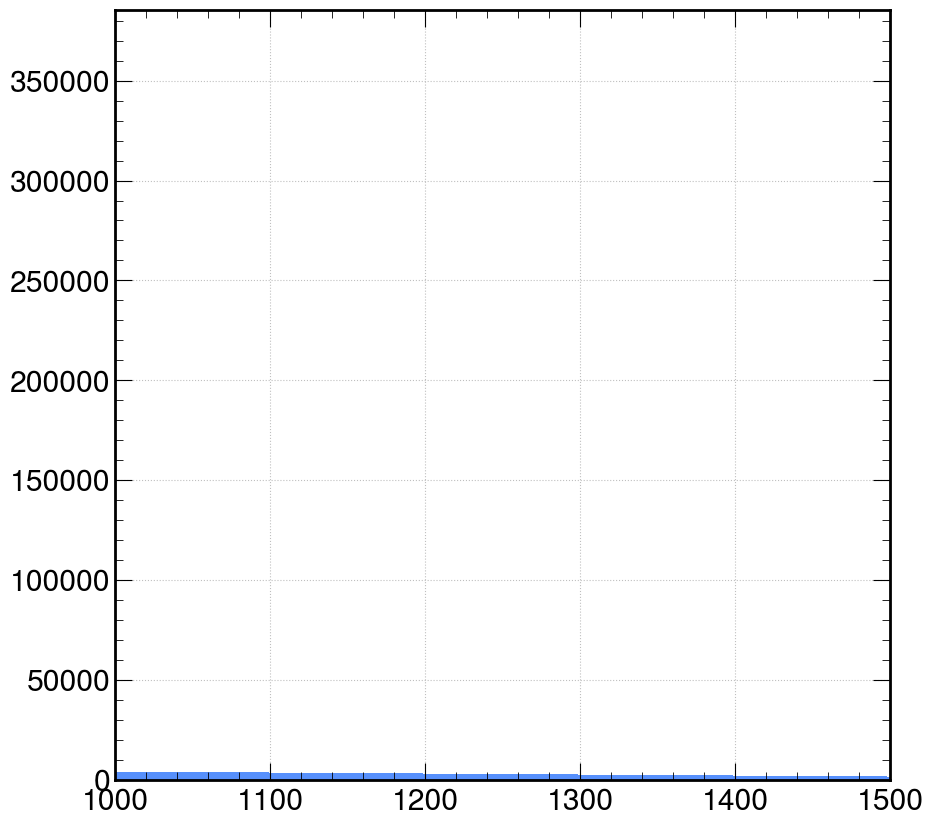

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

In [33]:
df_events

,Unnamed: 0,PID,status,Mmother1,mother2,color1,color2,px,py,pz,...,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol,neutrino,anti_neutrino
0,0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,26.295143,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Anti-Down Quark,d~,-1,NaN
1,1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-90.457148,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Down Quark,d,-1,NaN
2,2,12.0,1.0,1.0,2.0,0.0,0.0,13.148818,6.728541,-65.894337,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Electron Neutrino,ve,True,NaN
3,3,-12.0,1.0,1.0,2.0,0.0,0.0,-20.712857,-17.372946,14.740016,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Electron Anti-Neutrino,ve~,-1,True
4,4,22.0,1.0,1.0,2.0,0.0,0.0,7.564039,10.644405,-13.007682,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Photon,a,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,22.371330,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Anti-Up Quark,u~,-1,NaN
4999996,4999996,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-152.764759,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Up Quark,u,-1,NaN
4999997,4999997,14.0,1.0,1.0,2.0,0.0,0.0,-37.079267,-12.672226,-31.589324,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Muon Neutrino,vm,True,NaN
4999998,4999998,-14.0,1.0,1.0,2.0,0.0,0.0,36.702771,35.798366,-79.886091,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Muon Anti-Neutrino,vm~,-1,True


array([[<Axes: title={'center': 'E'}>]], dtype=object)

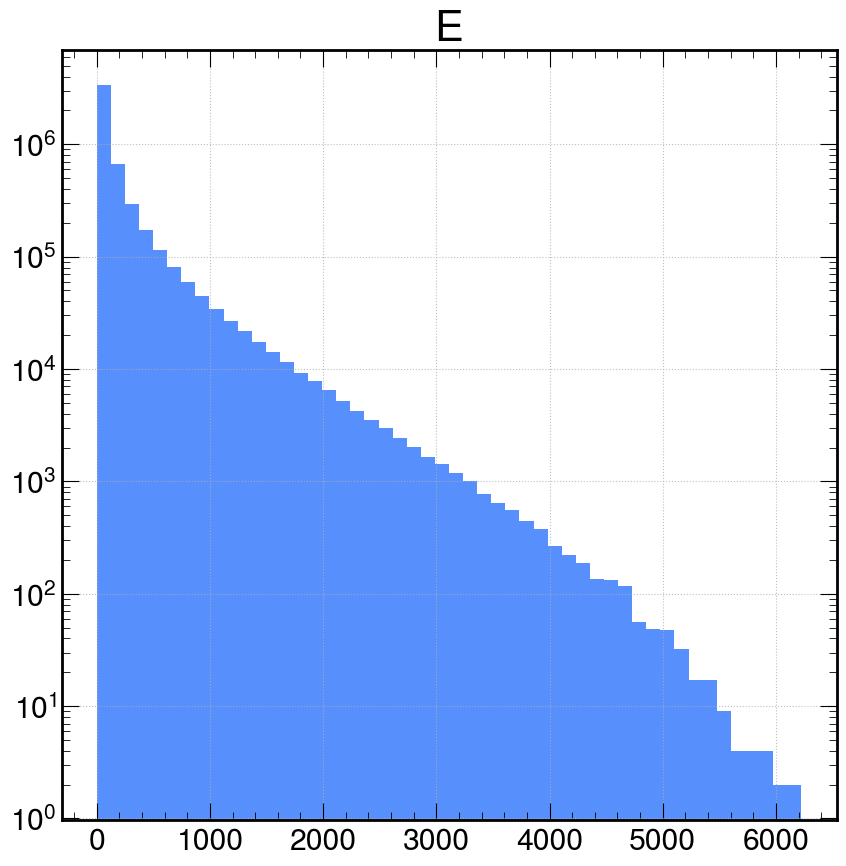

In [34]:
df_events.hist('E', bins=50, log=True)

In [ ]:
df_events

In [ ]:
df_events.merge(particle_df, on='PID', how='left')